# (01) Parcel: erode

**Motivation**: Explore ways to erode parcellation.  I used ```radius='infer'``` in fitting the parcellation. For the actual results, I will take the actual brain object and apply a ```radius='boundary'``` erosion before extractign functional signals. <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Explore Erode

In [2]:
mice = Mice(Config(128, resolution=25), load_parcel=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
from register.parcellation import erode_parcellation, infer_radius

In [4]:
x = mice.parcel['brain'].copy()

In [5]:
%%time

ids = unique_idxs(x)
len(ids)

CPU times: user 1.62 s, sys: 601 ms, total: 2.22 s
Wall time: 2.22 s


2782

In [6]:
%%time

infer_radius(x)

CPU times: user 2.77 s, sys: 2.81 s, total: 5.58 s
Wall time: 6.26 s


11.151836478762565

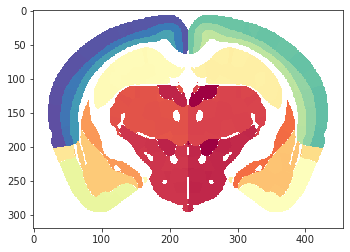

In [7]:
plt.imshow(mwh(x[300] == 0, x[300]), cmap='Spectral_r');

In [8]:
%%time

x_er, radius = erode_parcellation(x, radius='boundary')
x_er.shape, radius

CPU times: user 31.2 s, sys: 4.88 s, total: 36.1 s
Wall time: 35.7 s


((528, 320, 456), 'boundary')

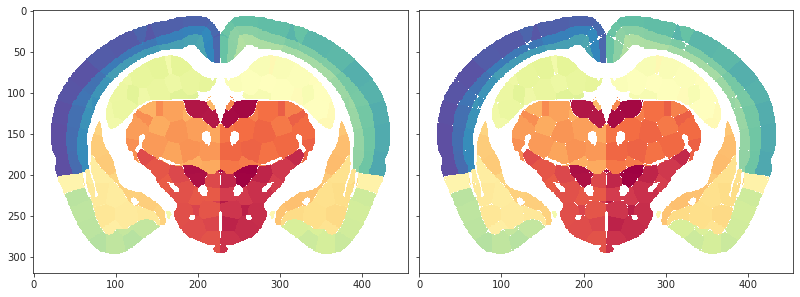

In [9]:
cmap = sns.color_palette('Spectral_r', as_cmap=True)
x2p = x[300].copy()
x2p_er = x_er[300].copy()
for i_new, i in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p[x2p == i] = i_new + 1
    x2p_er[x2p_er == i] = i_new + 1

fig, axes = create_figure(1, 2, (11, 4), 'all', 'all', constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=cmap)
axes[1].imshow(mwh(x2p_er == 0, x2p_er), cmap=cmap);

In [10]:
%%time

x_er, radius = erode_parcellation(x, radius='infer')
x_er.shape, radius

CPU times: user 16 s, sys: 7.1 s, total: 23.2 s
Wall time: 23.7 s


((528, 320, 456), 11.151836478762565)

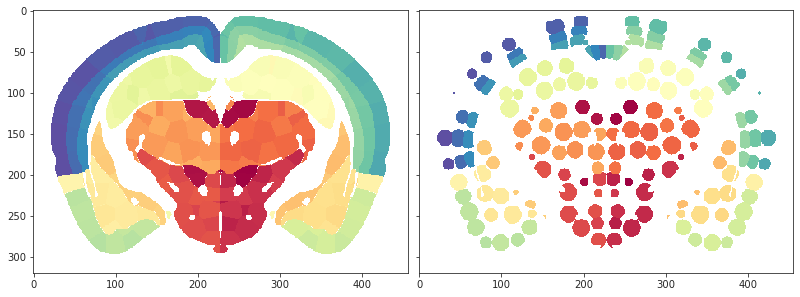

In [11]:
cmap = sns.color_palette('Spectral_r', as_cmap=True)
x2p = x[300].copy()
x2p_er = x_er[300].copy()
for i_new, i in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p[x2p == i] = i_new + 1
    x2p_er[x2p_er == i] = i_new + 1

fig, axes = create_figure(1, 2, (11, 4), 'all', 'all', constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=cmap)
axes[1].imshow(mwh(x2p_er == 0, x2p_er), cmap=cmap);

In [12]:
regions = np.unique(x_er[x_er.nonzero()])
len(regions), len(mice.parcel.df)

(2782, 2782)

In [13]:
self = mice.parcel

In [14]:
eroded = np.zeros_like(self['brain'])
eroded.shape

(528, 320, 456)

In [15]:
%%time

radii = {}
for acro in self.df['acro'].unique():
    df = self.df.loc[self.df['acro'] == acro]
    if acro == 'Isocortex':
        for layer in range(self.cfg.ll):
            ids = df.loc[
                df['layer'] == layer,
                'id',
            ].values
            x = self['cortex'].copy()
            m = np.isin(x, ids)
            x[~m] = 0
            x_er, radius = erode_parcellation(x, 'infer')
            radii[f"{acro}-{layer}"] = radius
            eroded[m] = x_er[m]
    else:
        ids = df['id'].values
        x = self['subcortex'].copy()
        m = np.isin(x, ids)
        x[~m] = 0
        x_er, radius = erode_parcellation(x, 'infer')
        radii[acro] = radius
        eroded[m] = x_er[m]

CPU times: user 1min 54s, sys: 1min 27s, total: 3min 22s
Wall time: 3min 27s


In [16]:
radii

{
    'Isocortex-0': 9.92442300129975,
    'Isocortex-1': 8.887676213336382,
    'Isocortex-2': 7.414800667454122,
    'OLF': 11.256438987618681,
    'HIP': 10.999789811131055,
    'RHP': 11.161067901238164,
    'CTXsp': 11.702355261454954,
    'STR': 11.263642126565298,
    'PAL': 10.855727806576645,
    'TH': 11.292224871973628,
    'HY': 11.538663267336496,
    'MB': 11.651804134407957,
    'P': 11.640668327352545,
    'MY': 11.715973056357198,
    'CB': 11.385943590169436
}

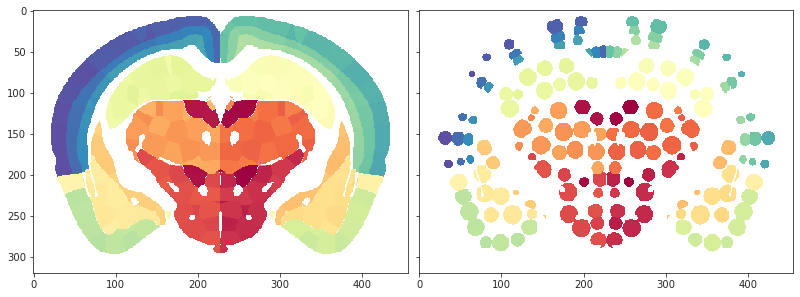

In [17]:
cmap = sns.color_palette('Spectral_r', as_cmap=True)
x2p = self['brain'][300].copy()
x2p_er = eroded[300].copy()
for i_new, i in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p[x2p == i] = i_new + 1
    x2p_er[x2p_er == i] = i_new + 1

fig, axes = create_figure(1, 2, (11, 4), 'all', 'all', constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=cmap)
axes[1].imshow(mwh(x2p_er == 0, x2p_er), cmap=cmap);

In [18]:
regions_final = np.unique(eroded[eroded.nonzero()])
len(regions_final), len(self.df)

(2782, 2782)

In [16]:
regions_final = np.unique(eroded[eroded.nonzero()])
len(regions_final), len(self.df)

(2782, 2782)

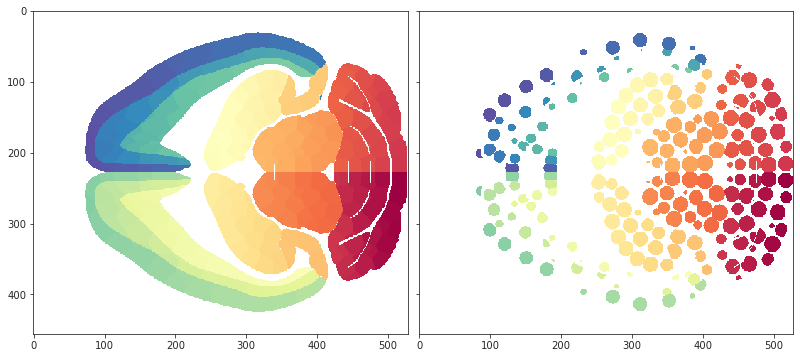

In [26]:
cmap = sns.color_palette('Spectral_r', as_cmap=True)
x2p = self['brain'][:, 100].T.copy()
x2p_er = eroded[:, 100].T.copy()
for i_new, i in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p[x2p == i] = i_new + 1
    x2p_er[x2p_er == i] = i_new + 1

fig, axes = create_figure(1, 2, (11, 5), 'all', 'all', constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=cmap)
axes[1].imshow(mwh(x2p_er == 0, x2p_er), cmap=cmap);

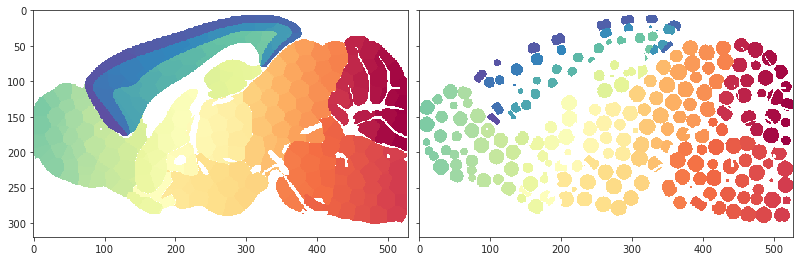

In [27]:
cmap = sns.color_palette('Spectral_r', as_cmap=True)
x2p = self['brain'][..., 200].T.copy()
x2p_er = eroded[..., 200].T.copy()
for i_new, i in enumerate(np.unique(x2p[x2p.nonzero()])):
    x2p[x2p == i] = i_new + 1
    x2p_er[x2p_er == i] = i_new + 1

fig, axes = create_figure(1, 2, (11, 5), 'all', 'all', constrained_layout=True)
axes[0].imshow(mwh(x2p == 0, x2p), cmap=cmap)
axes[1].imshow(mwh(x2p_er == 0, x2p_er), cmap=cmap);

In [67]:
eroded.dtype

dtype('uint32')

In [28]:
eroded.shape

(528, 320, 456)

In [29]:
from register.register import Register
reg = Register(mice)
reg.mi_base = ants.image_mutual_information(
    image1=reg.template, image2=reg.template)

In [32]:
tx_fwd, tx_aff = reg.load_tx(reg.in_house_name, is_inv=False)
tx_inv, _ = reg.load_tx(reg.in_house_name, is_inv=True)
tx = {'fwdtransforms': tx_fwd, 'invtransforms': tx_inv}
tx_aff_inv = tx_aff.invert()

affined = tx_aff.apply_to_image(
    image=reg.in_house,
    reference=reg.template,
    interpolation='linear',
)

In [33]:
obj = ants.apply_transforms(
    fixed=affined,
    moving=reg.img_in_ccf(eroded),
    transformlist=tx['invtransforms'],
    interpolator='genericLabel',
)
obj = tx_aff_inv.apply_to_image(
    image=obj,
    reference=reg.in_house,
    interpolation='multilabel',
)
obj = obj.numpy()
#for i_new, i in enumerate(np.unique(obj[obj.nonzero()])):
#    obj[obj == i] = i_new + 1

In [34]:
obj.shape

(81, 46, 60)

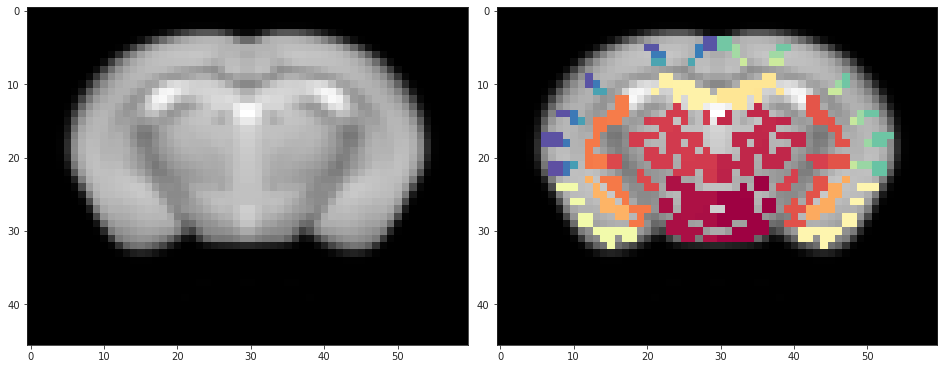

In [35]:
fig, axes = create_figure(1, 2, (13, 5), constrained_layout=True)
s_ = 37
for ax in axes.flat:
    ax.imshow(reg.in_house[s_], cmap='Greys_r')
axes[1].imshow(mwh(obj[s_] == 0, obj[s_]), alpha=1, cmap='Spectral_r')
plt.show()

In [39]:
size = unique_idxs(obj.astype('uint32'))
size = {i: len(v) for i, v in size.items()}

In [41]:
len(size)

2756

In [55]:
diff = sorted(set(mice.parcel.df['id'].unique()) - set(size))
len(diff)

26

In [62]:
mice.parcel(2)

{'id': 2, 'acro': 'Isocortex', 'hemis': 1, 'region': 2, 'layer': 0}

In [63]:
diff[0]

128

In [64]:
mice.parcel.df.loc[mice.parcel.df['id'].isin(diff)]

,id,acro,hemis,region,layer
127,128,Isocortex,1,128,0
257,258,Isocortex,1,2,2
258,259,Isocortex,1,3,2
259,260,Isocortex,1,4,2
263,264,Isocortex,1,8,2
265,266,Isocortex,1,10,2
344,345,Isocortex,1,89,2
345,346,Isocortex,1,90,2
347,348,Isocortex,1,92,2
353,354,Isocortex,1,98,2


In [65]:
diff_sym = mice.parcel.complement(diff)
len(diff_sym)

30

In [66]:
mice.parcel.df.loc[mice.parcel.df['id'].isin(diff_sym)]

,id,acro,hemis,region,layer
127,128,Isocortex,1,128,0
208,209,Isocortex,1,81,1
257,258,Isocortex,1,2,2
258,259,Isocortex,1,3,2
259,260,Isocortex,1,4,2
263,264,Isocortex,1,8,2
265,266,Isocortex,1,10,2
286,287,Isocortex,1,31,2
344,345,Isocortex,1,89,2
345,346,Isocortex,1,90,2


## Fit new

In [2]:
mice = Mice(Config(128, resolution=25))

[PROGRESS] 'config.json' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
%%time

mice.parcel.fit_parcel('infer', True)

[PROGRESS] fit columnar: initiated

[PROGRESS] kmeans fit: done

[PROGRESS] save 2D 10um: done

[PROGRESS] 2d --> 3d: done

[PROGRESS] save 3D 10um: done

[PROGRESS] downsample: done

num regions,    left: 384,  right: 384
region id diff,         r - l:  Counter({384: 384})

[PROGRESS] fit columnar: done

[PROGRESS] fit subcortical: initiated

[PROGRESS] 'cols_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'brain_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'cortex_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'subcortex_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'cortex-top_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'brain-eroded_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'nonzero-idxs_parcel2d-flat_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'nonzero-idxs_parcel2d-top_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'nonzero-idxs_parcel3d_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'region-idxs_parcel2d-flat_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'region-idxs_parcel2d-top_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'region-idxs_parcel3d_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'shape_parcel2d-flat_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'shape_parcel2d-top_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'shape_parcel3d_25um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'regions.df' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'fit_meta.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] save results: done.

CPU times: user 1d 12h 16min 55s, sys: 1h 57min 47s, total: 1d 14h 14min 42s
Wall time: 4h 40min 25s


In [4]:
mice = Mice(Config(128, resolution=100))

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [5]:
%%time

mice.parcel.fit_parcel('infer', True)

[PROGRESS] fit columnar: initiated

[PROGRESS] downsample: done

num regions,    left: 384,  right: 384
region id diff,         r - l:  Counter({384: 384})

[PROGRESS] fit columnar: done

[PROGRESS] fit subcortical: initiated

[PROGRESS] fit subcortical: done

[PROGRESS] create regions df: done

[PROGRESS] 'cols_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'brain_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'cortex_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'subcortex_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'cortex-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'brain-eroded_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'nonzero-idxs_parcel2d-flat_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'nonzero-idxs_parcel2d-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'nonzero-idxs_parcel3d_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'region-idxs_parcel2d-flat_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'region-idxs_parcel2d-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'region-idxs_parcel3d_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'shape_parcel2d-flat_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'shape_parcel2d-top_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'shape_parcel3d_100um.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'regions.df' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] 'fit_meta.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-128*3/parcellation

[PROGRESS] save results: done.

CPU times: user 38min 32s, sys: 3min 26s, total: 41min 58s
Wall time: 4min 23s


In [9]:
mice.parcel['eroded-radii']

{
    'Isocortex-0': 2.719102115583514,
    'Isocortex-1': 2.233832815502203,
    'Isocortex-2': 1.8823941872447283,
    'OLF': 2.669839833942877,
    'HIP': 2.652555978765983,
    'RHP': 2.6140985274298894,
    'CTXsp': 2.6638303574795232,
    'STR': 2.7045961467468294,
    'PAL': 2.543543915675433,
    'TH': 2.7392922989650064,
    'HY': 2.7331860495012856,
    'MB': 2.763917601219168,
    'P': 2.7245725993175265,
    'MY': 2.7950540439064877,
    'CB': 2.678951334283115
}

## Look, which one?

In [2]:
from register.register import Register

mice = Mice(Config(128, resolution=25))
reg = Register(mice)
in_house = reg.load_in_house().numpy()

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
brain = 'Symmetric_N162_space-indiv3d_brain.nii.gz'
brain = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, brain),
    pixeltype='unsigned int',
).numpy()
eroded = 'Symmetric_N162_space-indiv3d_brain-eroded.nii.gz'
eroded = ants.image_read(
    filename=pjoin(mice.cfg.masks_dir, eroded),
    pixeltype='unsigned int',
).numpy()

brain.shape, eroded.shape

((60, 46, 81), (60, 46, 81))

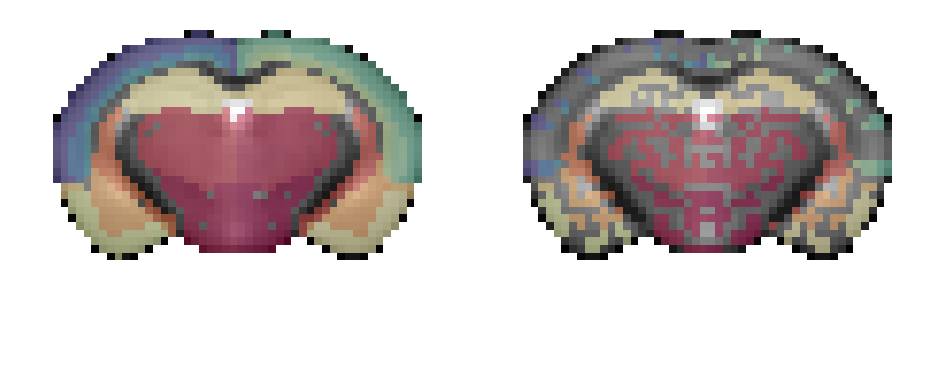

In [4]:
fig, axes = create_figure(1, 2, (13, 7), 'all', 'all', constrained_layout=True)

x2p1 = brain[..., 40].T
x2p2 = eroded[..., 40].T

for ax in axes.flat:
    ax.imshow(mwh(in_house[..., 40].T < 4000, in_house[..., 40].T), cmap='Greys_r')

axes[0].imshow(mwh(x2p1 == 0, x2p1), alpha=0.5, cmap='Spectral_r')
axes[1].imshow(mwh(x2p2 == 0, x2p2), alpha=0.5, cmap='Spectral_r')
remove_ticks(axes)
plt.show()

In [5]:
from register.parcellation import erode_parcellation, sp_spat

In [39]:
eroded2, r = erode_parcellation(brain, 'boundary')
eroded2.shape, r

((60, 46, 81), 'boundary')

In [40]:
data2p = filter_boundaries(
    x_list=[brain[..., 40].T, eroded[..., 40].T, eroded2[..., 40].T, in_house[..., 40].T],
    mask=in_house[..., 40].T > 4000,
)

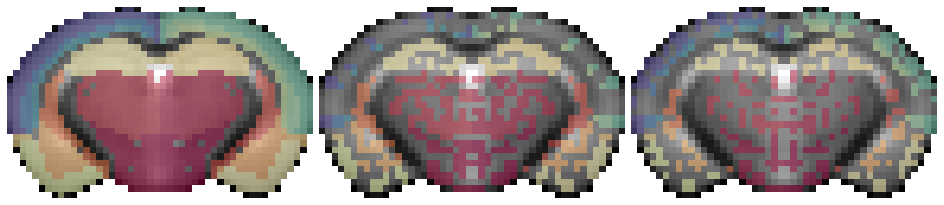

In [41]:
fig, axes = create_figure(1, 3, (13, 4), 'all', 'all', constrained_layout=True)

for ax in axes.flat:
    ax.imshow(mwh(data2p[-1] < 4000, data2p[-1]), cmap='Greys_r')

for i, x2p in enumerate(data2p[:-1]):
    axes[i].imshow(mwh(x2p == 0, x2p), alpha=0.5, cmap='Spectral_r')
remove_ticks(axes)
plt.show()

In [42]:
ids_x = list(unique_idxs(eroded2))
len(ids_x)

2700

In [43]:
missing = sorted(set(unique_idxs(brain)) - set(ids_x))
len(missing)

78

In [44]:
m = np.isin(brain, missing)
eroded2[m] = brain[m]

In [45]:
ids_x = list(unique_idxs(eroded2))
len(ids_x)

2778

In [48]:
missing = sorted(set(mice.parcel.df['id']) - set(unique_idxs(brain)))
missing

[258, 362, 642, 746]

In [51]:
data2p = filter_boundaries(
    x_list=[brain[..., 40].T, eroded[..., 40].T, eroded2[..., 40].T, in_house[..., 40].T],
    mask=in_house[..., 40].T > 4000,
)

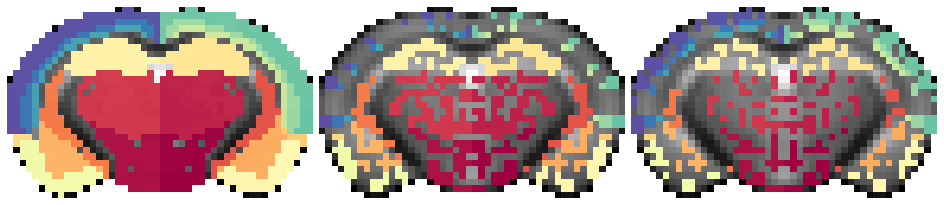

In [52]:
fig, axes = create_figure(1, 3, (13, 4), 'all', 'all', constrained_layout=True)

for ax in axes.flat:
    ax.imshow(mwh(data2p[-1] < 4000, data2p[-1]), cmap='Greys_r')

for i, x2p in enumerate(data2p[:-1]):
    axes[i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')
remove_ticks(axes)
plt.show()

In [70]:
data2p = filter_boundaries(
    x_list=[brain[:, 10], eroded[:, 10], eroded2[:, 10], in_house[:, 10]],
    mask=in_house[:, 10] > 4000,
)

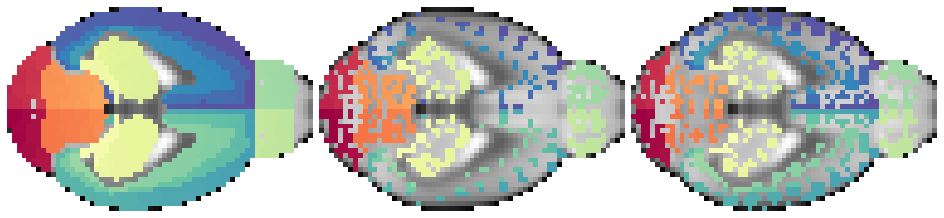

In [71]:
fig, axes = create_figure(1, 3, (13, 4), 'all', 'all', constrained_layout=True)

for ax in axes.flat:
    ax.imshow(mwh(data2p[-1] < 4000, data2p[-1]), cmap='Greys_r')

for i, x2p in enumerate(data2p[:-1]):
    axes[i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')
remove_ticks(axes)
plt.show()

In [88]:
data2p = filter_boundaries(
    x_list=[brain[24], eroded[24], eroded2[24], in_house[24]],
    mask=in_house[24] > 2000,
)

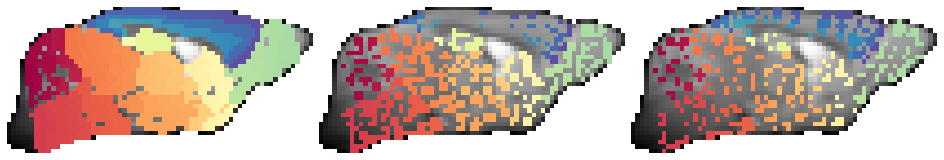

In [89]:
fig, axes = create_figure(1, 3, (13, 4), 'all', 'all', constrained_layout=True)

for ax in axes.flat:
    ax.imshow(mwh(data2p[-1] < 2000, data2p[-1]), cmap='Greys_r')

for i, x2p in enumerate(data2p[:-1]):
    axes[i].imshow(mwh(x2p == 0, x2p), alpha=1, cmap='Spectral_r')
remove_ticks(axes)
plt.show()

In [90]:
missing = sorted(set(unique_idxs(brain)) - set(unique_idxs(eroded)))
len(missing)

22

In [91]:
m = np.isin(brain, missing)
eroded[m] = brain[m]

In [92]:
sizes_brain = unique_idxs(brain)
sizes_1 = unique_idxs(eroded)
sizes_2 = unique_idxs(eroded2)

sizes_brain = {i: len(v) for i, v in sizes_brain.items()}
sizes_1 = {i: len(v) for i, v in sizes_1.items()}
sizes_2 = {i: len(v) for i, v in sizes_2.items()}

len(sizes_brain), len(sizes_1), len(sizes_2)

(2778, 2778, 2778)

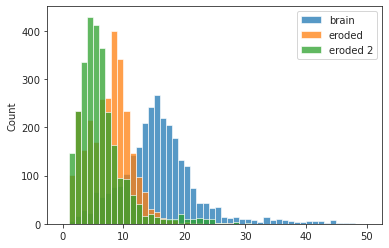

In [99]:
sns.histplot(list(sizes_brain.values()), color='C0', label='brain', bins=np.linspace(0, 50, 51))
sns.histplot(list(sizes_1.values()), color='C1', label='eroded', bins=np.linspace(0, 50, 51))
sns.histplot(list(sizes_2.values()), color='C2', label='eroded 2', bins=np.linspace(0, 50, 51))
plt.legend()
plt.show()